###IMPORTACIÓN DE LIBRERÍAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno 
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

###CARGA DEL DATASET

In [2]:
#dataset = pd.read_csv("dataset_peliculas_chilenas.csv", index_col="ID")
dataset = pd.read_csv("dataset_peliculas_chilenas_v2.csv", index_col="ID")
dataset.head()

,Title,Year,Age,IMDb,CineChile,Directors,Genres,Language,Runtime
ID,,,,,,,,,
1,El Chacal de Nahueltoro,1969,NaN,7.7,457.0,Miguel Littin,"Biography, Crime, Drama",Spanish,95
2,Tres Tristes Tigres,1968,NaN,7.2,369.0,Raúl Ruiz,Drama,Spanish,100
3,Valparaíso Mi Amor,1969,13+,7.3,225.0,Aldo Francia,Drama,Spanish,90
4,La Batalla de Chile la lucha de un pueblo sin ...,1975,NaN,8.3,207.0,Patricio Guzmán,Documentary,Spanish,97
5,Largo Viaje,1967,NaN,7.6,186.0,Patricio Kaulen,Drama,Spanish,83


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 1 to 87
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      87 non-null     object 
 1   Year       87 non-null     int64  
 2   Age        45 non-null     object 
 3   IMDb       87 non-null     float64
 4   CineChile  60 non-null     float64
 5   Directors  87 non-null     object 
 6   Genres     84 non-null     object 
 7   Language   87 non-null     object 
 8   Runtime    87 non-null     int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 6.8+ KB


In [4]:
dataset.isna().sum()

Title         0
Year          0
Age          42
IMDb          0
CineChile    27
Directors     0
Genres        3
Language      0
Runtime       0
dtype: int64

In [5]:
#Quedando con los no nulos
dataset = dataset[dataset['IMDb'].notna()]

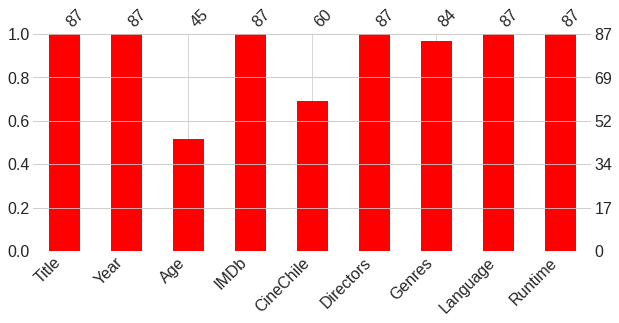

In [6]:
#Visualizando la cantidad de datos que faltan
msno.bar(dataset ,color='red', figsize=(10, 4))

In [7]:
#Eliminando columna "CineChile" 
dataset = dataset.drop(['CineChile'], axis=1)
#dataset = dataset.drop(['IMDb'], axis=1)

#"Title" se elimina por ser irrelevante para nuestra predicción.
dataset = dataset.drop(['Title'], axis=1)
#Eliminamos los cortos (<60min de duración)
dataset = dataset.drop(dataset[dataset['Runtime']<60].index)
dataset.isna().sum()

Year          0
Age          35
IMDb          0
Directors     0
Genres        3
Language      0
Runtime       0
dtype: int64

In [8]:
#Comprobando valores únicos en "Age" 
dataset['Age'].unique()

array([nan, '13+', 'all', '18+', '7+'], dtype=object)

In [9]:
#Imputando valores nulos en "Age" con "all"
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="all")
dataset["Age"] = imputer.fit_transform(dataset[["Age"]]).ravel()

dataset.isna().sum()

Year         0
Age          0
IMDb         0
Directors    0
Genres       3
Language     0
Runtime      0
dtype: int64

In [10]:
#Eliminando todas las filas(entradas) en las que hay celdas sin datos
dataset.dropna(axis=0, how='any',inplace=True)

dataset.isna().sum()

Year         0
Age          0
IMDb         0
Directors    0
Genres       0
Language     0
Runtime      0
dtype: int64

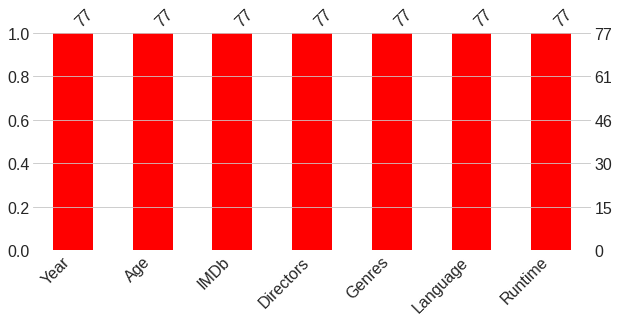

In [11]:
#Visualizar si faltan más datos o no
msno.bar(dataset ,color='red', figsize=(10, 4))

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 87
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       77 non-null     int64  
 1   Age        77 non-null     object 
 2   IMDb       77 non-null     float64
 3   Directors  77 non-null     object 
 4   Genres     77 non-null     object 
 5   Language   77 non-null     object 
 6   Runtime    77 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 4.8+ KB


In [13]:
#Elegimos el objetivo(IMDb) y las características
y = dataset.IMDb
#y = dataset.CineChile

X = dataset.drop(['IMDb'], axis=1)
#X = dataset.drop(['CineChile'], axis=1)

#Dividiendo los datos para el entrenamiento y la prueba
X_train_full, X_test_full, y_train, y_test  = train_test_split(X, y,random_state = 0)

#Lista de columnas categóricas que se utilizarán como características
cat_cols=["Age","Directors","Genres","Language"]

#Lista de columnas numéricas que se utilizarán como características
numerical_cols = ['Year','Runtime']

#Mantener sólo las columnas seleccionadas
my_cols = numerical_cols + cat_cols 
X_train = X_train_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

###ENTRENAMIENTO Y TESTEO

In [14]:
#Visualización de datos de entrenamiento
X_train.head()

,Year,Runtime,Age,Directors,Genres,Language
ID,,,,,,
72,2020,93,13+,Rodrigo Sepúlveda,"Drama, History, Romance",Spanish
64,2016,85,all,Christoper Murray,Drama,Spanish
73,2020,135,7+,David Albala,"Drama, Thriller",Spanish
67,2015,88,13+,Matías Bize,"Drama, Romance",Spanish
83,2013,73,18+,George Vonknorring,"Action, Crime",Spanish


In [16]:
#Visualización de datos de prueba
X_test.head()

,Year,Runtime,Age,Directors,Genres,Language
ID,,,,,,
57,1974,60,all,Raúl Ruiz,Drama,Spanish
85,2007,90,all,Ernesto Díaz Espinoza,"Animation, Action, Comedy, Crime, Family",Spanish
70,2020,91,18+,Gaspar Antillo,"Drama, Music","Spanish, English"
65,2006,110,all,Pablo Larraín,"Drama, Music, Thriller",Spanish
37,2000,140,13+,Silvio Caiozzi,"Drama, Romance",Spanish


In [17]:
#Copiando los datos para evitar el cambio en el dataset original
label_X_train = X_train.copy()
label_X_test = X_test.copy()

#Aplicar el codificador de etiquetas a cada columna con datos categóricos
label_encoder = LabelEncoder()
for col in cat_cols:
    label_encoder.fit(pd.concat([label_X_train[col], label_X_test[col]], axis=0, sort=False))
    label_X_train[col] = label_encoder.transform(label_X_train[col])
    label_X_test[col] = label_encoder.transform(label_X_test[col])

###Modelos

In [23]:
#Modelos Definidos
model_1 = RandomForestRegressor(n_estimators=50, random_state=1)
model_2 = RandomForestRegressor(n_estimators=100, random_state=1)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=1)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=1)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=1)

model_6 = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=1)
model_7 = RandomForestRegressor(n_estimators=300, max_depth=9, random_state=1)
model_8 = RandomForestRegressor(n_estimators=400, max_depth=8, random_state=1)
model_9 = RandomForestRegressor(n_estimators=500, min_samples_split=20, max_depth=10, random_state=1)
model_10 = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=1)

#Lista de modelos
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]

###Resultados

In [24]:
#Función para comparar diferentes modelos
def score_model(model, X_t=label_X_train, X_v=label_X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)
mae_scores=[]
for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Modelo %d MAE(Error medio absoluto): %f" % (i+1, mae))
    mae_scores.append(mae)

Modelo 1 MAE(Error medio absoluto): 0.481400
Modelo 2 MAE(Error medio absoluto): 0.479400
Modelo 3 MAE(Error medio absoluto): 0.457450
Modelo 4 MAE(Error medio absoluto): 0.450187
Modelo 5 MAE(Error medio absoluto): 0.482624
Modelo 6 MAE(Error medio absoluto): 0.485964
Modelo 7 MAE(Error medio absoluto): 0.457808
Modelo 8 MAE(Error medio absoluto): 0.452970
Modelo 9 MAE(Error medio absoluto): 0.453152
Modelo 10 MAE(Error medio absoluto): 0.460157


In [25]:
best_score=min(mae_scores)
print(best_score)
print("Mejor Puntaje {0:.1f}% de error medio absoluto".format((best_score) * 100))

0.4501872404688215
Mejor Puntaje 45.0% de error medio absoluto


###Exportación del Modelo

In [27]:
from sklearn.externals import joblib
joblib.dump(model_4, 'modelo_movieratingprediction.joblib')

['modelo_movieratingprediction.joblib']